In [1]:
#Libraries to handle data
import numpy as np
import pandas as pd

#Libraries to visualize
import matplotlib.pyplot as plt
import seaborn as sns

#Libraries for spliting data
from sklearn.model_selection import train_test_split

#Libraries for Processing data
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.preprocessing import FunctionTransformer
from category_encoders import CatBoostEncoder
from sklearn.base import BaseEstimator, TransformerMixin


#Libraries for modeling
from sklearn.model_selection import StratifiedKFold,GridSearchCV
from sklearn.linear_model import LogisticRegression
from catboost import CatBoostClassifier
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer

#Libraries for scoring
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import RocCurveDisplay,roc_auc_score
from sklearn.metrics import roc_curve, auc

In [3]:
# Read the CSV file named 'train.csv' located in the 'data' folder and set the column named 'id' as the index
# Store the data in a DataFrame named 'train'
train = pd.read_csv('../data/train.csv', index_col='id')

# Display concise information about the 'train' DataFrame, including the data types and non-null counts of each column
train.info()

# Read the CSV file named 'test.csv' located in the 'data' folder and set the column named 'id' as the index
# Store the data in a DataFrame named 'test'
test = pd.read_csv('../data/test.csv',index_col='id')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 165034 entries, 0 to 165033
Data columns (total 13 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   CustomerId       165034 non-null  int64  
 1   Surname          165034 non-null  object 
 2   CreditScore      165034 non-null  int64  
 3   Geography        165034 non-null  object 
 4   Gender           165034 non-null  object 
 5   Age              165034 non-null  float64
 6   Tenure           165034 non-null  int64  
 7   Balance          165034 non-null  float64
 8   NumOfProducts    165034 non-null  int64  
 9   HasCrCard        165034 non-null  float64
 10  IsActiveMember   165034 non-null  float64
 11  EstimatedSalary  165034 non-null  float64
 12  Exited           165034 non-null  int64  
dtypes: float64(5), int64(5), object(3)
memory usage: 17.6+ MB


In [3]:
#Sanity Check
train.sample(5)

,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
id,,,,,,,,,,,,,
69803,15709917,Iadanza,562,France,Male,39.0,6,0.00,1,1.0,1.0,93901.61,0
36271,15658052,Pirozzi,679,Germany,Female,36.0,9,96679.72,1,1.0,1.0,177866.79,0
41419,15804781,Okeke,684,Spain,Female,37.0,8,121063.70,2,0.0,0.0,136520.92,0
160166,15794323,Buckley,673,France,Male,32.0,8,0.00,2,1.0,0.0,116969.73,0
108163,15587421,Chukwuebuka,687,Spain,Male,35.0,8,125211.55,3,0.0,1.0,176450.19,1


### EDA

Initial Analysis

In [4]:
# Generate a descriptive DataFrame 'desc' summarizing various statistics of the 'train' DataFrame's columns
desc = pd.DataFrame(index = list(train))
desc['type'] = train.dtypes
desc['count'] = train.count()
desc['nunique'] = train.nunique()
desc['%unique'] = desc['nunique'] / len(train) * 100
desc['null'] = train.isnull().sum()
desc['%null'] = desc['null'] / len(train) * 100
desc['min'] = train.min()
desc['max'] = train.max()
desc

,type,count,nunique,%unique,null,%null,min,max
CustomerId,int64,165034,23221,14.070434,0,0.0,15565701,15815690
Surname,object,165034,2797,1.694802,0,0.0,Abazu,Zuyeva
CreditScore,int64,165034,457,0.276913,0,0.0,350,850
Geography,object,165034,3,0.001818,0,0.0,France,Spain
Gender,object,165034,2,0.001212,0,0.0,Female,Male
Age,float64,165034,71,0.043021,0,0.0,18.0,92.0
Tenure,int64,165034,11,0.006665,0,0.0,0,10
Balance,float64,165034,30075,18.223518,0,0.0,0.0,250898.09
NumOfProducts,int64,165034,4,0.002424,0,0.0,1,4
HasCrCard,float64,165034,2,0.001212,0,0.0,0.0,1.0


Univariate Analysis

In [5]:
# Select numeric columns from the 'train' DataFrame
numeric_columns = train.select_dtypes(include=['number'])

# Iterate through each numeric column, creating individual bar plots for the relationship with the 'Exited' column
for col in numeric_columns:
    plt.figure(figsize=(8, 4))
    sns.barplot(y=col, x="Exited", data=train)
    plt.title(f'Barplot for {col} vs Exited')
    plt.xlabel('Exited')
    plt.ylabel(col)
    plt.show()

'for col in numeric_columns:\n    plt.figure(figsize=(8, 4))\n    sns.barplot(y=col, x="Exited", data=train)\n    plt.title(f\'Barplot for {col} vs Exited\')\n    plt.xlabel(\'Exited\')\n    plt.ylabel(col)\n    plt.show()'

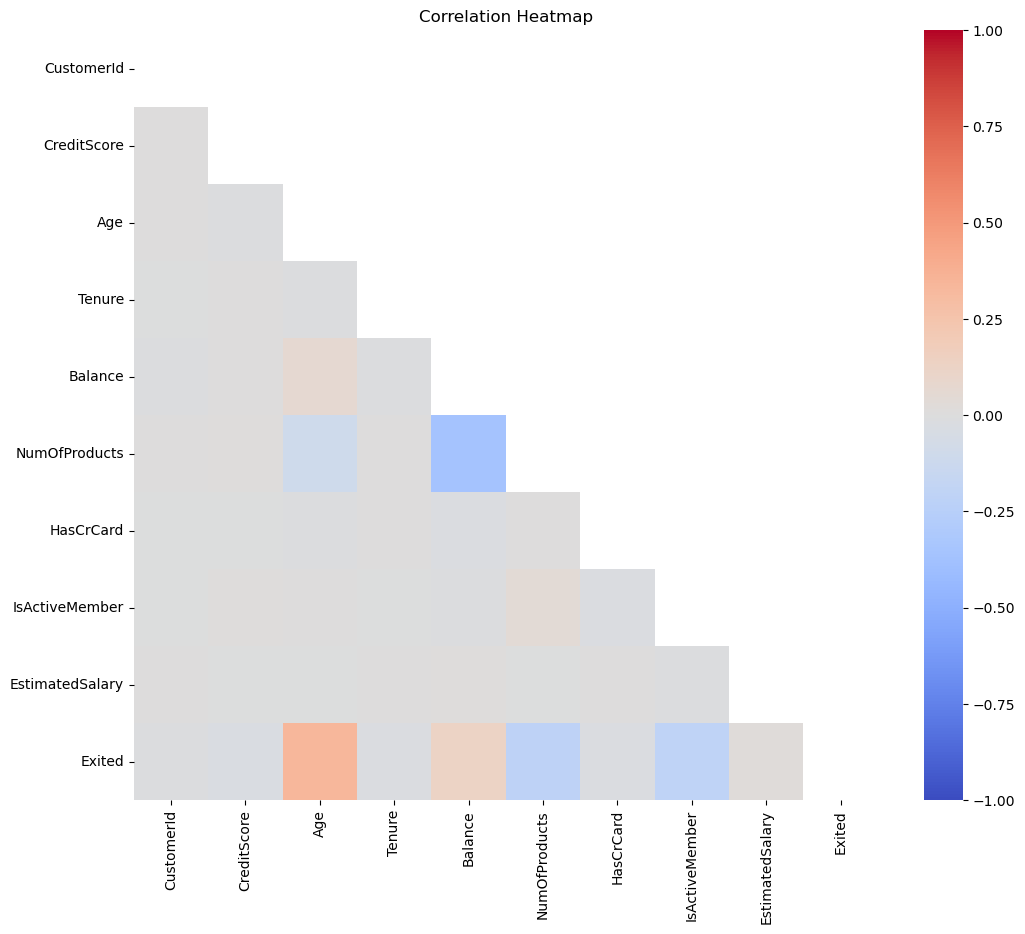

In [6]:
#Checking for correlation to drop correlating variables if necessary
corr_df = train.corr(numeric_only=True)
mask_ut = np.triu(np.ones(corr_df.shape)).astype(bool)

plt.figure(figsize=(12, 10))
sns.heatmap(corr_df, cmap='coolwarm', fmt='.2f', vmin=-1.0, vmax=1.0,mask=mask_ut)
plt.title('Correlation Heatmap')
plt.show()

Bivariate analysis

In [7]:
Country_data = train.groupby('Geography').sum()

/tmp/ipykernel_12022/2544608375.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  Country_data = train.groupby('Geography').sum()


In [8]:
Country_data['Exited']

Geography
France     15572
Germany    13114
Spain       6235
Name: Exited, dtype: int64

In [9]:
Gender_data = train.groupby('Gender').sum()

/tmp/ipykernel_12022/2148721.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  Gender_data = train.groupby('Gender').sum()


In [10]:
Gender_data['Exited']

Gender
Female    20105
Male      14816
Name: Exited, dtype: int64

### Data Preparation

In [11]:
# Separate the features (X) and the target variable (y) from the 'train' DataFrame
X, y = train.drop("Exited", axis=1), train.Exited

In [12]:
# Split the dataset into training and testing sets for features (X) and target variable (y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42,stratify=y)

### Feature Engeneering

In [13]:
X_train.dtypes

CustomerId           int64
Surname             object
CreditScore          int64
Geography           object
Gender              object
Age                float64
Tenure               int64
Balance            float64
NumOfProducts        int64
HasCrCard          float64
IsActiveMember     float64
EstimatedSalary    float64
dtype: object

In [14]:
# Define lists for numerical and categorical features
numerical_features = ['Balance','EstimatedSalary']
cat_features = ['CustomerId', 
                'Surname', 
                'Geography', 
                'Gender', 
                'Tenure', 
                'NumOfProducts', 
                'IsActiveMember', 
                'CreditScore', 
                'AllCat', 
                'IsActive_by_CreditCard',
                #'AgeCat',
                'Age',
                'HasCrCard'
               ]

In [15]:
# Define a custom transformer class 'FeatureSelector' that selects specified features
class FeatureSelector(TransformerMixin):
    def __init__(self, feature_names):
        self.feature_names = feature_names
    def fit(self, X, y = None):
        return self
    def transform(self, X, y = None):
        # Return a copy of the DataFrame with only the selected features
        return X.loc[:,self.feature_names].copy()

In [17]:
# Define a custom transformer class 'Feature_Creation' for creating additional features
class Feature_Creation(BaseEstimator,TransformerMixin):
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        
        # Create new features based on existing ones
        X_copy = X.copy()
        X_copy['IsActive_by_CreditCard'] = (X_copy['HasCrCard'] * X_copy['IsActiveMember']).astype(np.uint64)
        X_copy['Products_Per_Tenure'] = X_copy['Tenure'] / X_copy['NumOfProducts']
        #X_copy['AgeCat'] = np.round(X_copy.Age / 20).astype('int').astype('category')
        X_copy['AllCat'] = X_copy['Surname'] + X_copy['Geography'] + X_copy['Gender'] + np.round(X_copy.EstimatedSalary).astype('str')
        X_copy['IsActiveMember'] = X_copy['IsActiveMember'].astype(np.uint64)
        X_copy['Age'] = (X_copy['Age']*10).astype(np.uint64)
        X_copy['EstimatedSalary'] = (X_copy['EstimatedSalary']*10)
        X_copy['HasCrCard'] = X_copy['HasCrCard'].astype(np.uint64)
        
        return X_copy

### Preprocessing

In [16]:
# Create a numerical feature pipeline using FeatureSelector and StandardScaler
numerical_pipeline = Pipeline(steps = [
    ('selector',FeatureSelector(numerical_features)),
    ('std_scaler',StandardScaler())
])

In [18]:
# Create a categorical feature pipeline using Feature_Creation, FeatureSelector, and OneHotEncoder
categorical_pipeline = Pipeline(steps= [
    ('feature_eng',Feature_Creation()),
    ('selector', FeatureSelector(cat_features)),
    ('ohe', OneHotEncoder(handle_unknown='ignore',min_frequency=5))
])

In [19]:
#Sanity Check
X_train_transformed = categorical_pipeline.fit_transform(X_train,y_train)

In [20]:
X_train_transformed.get_shape()

(132027, 11119)

In [21]:
# Combine numerical and categorical pipelines into a single preprocessor using FeatureUnion
preprocessor = FeatureUnion(
    n_jobs=-1,
    transformer_list=[
    ('num',numerical_pipeline),
    ('cat',categorical_pipeline)
])

### Base Model

In [22]:
# Create a pipeline for Logistic Regression with preprocessing
Log = Pipeline(steps=[
    ('preprocessor',preprocessor),
    ('classifier',LogisticRegression(n_jobs=-1))
])

In [23]:
Log.fit(X_train,y_train)

/home/mdsv9/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Pipeline(steps=[('preprocessor',
                 FeatureUnion(n_jobs=-1,
                              transformer_list=[('num',
                                                 Pipeline(steps=[('selector',
                                                                  <__main__.FeatureSelector object at 0x7f589bc51750>),
                                                                 ('std_scaler',
                                                                  StandardScaler())])),
                                                ('cat',
                                                 Pipeline(steps=[('feature_eng',
                                                                  Feature_Creation()),
                                                                 ('selector',
                                                                  <__main__.FeatureSelector object at 0x7f5898d6d930>),
                                                                 ('ohe',
                                                                  OneHotEncoder(handle_unknown='ignore',
                                                                                min_frequency=5))]))])),
                ('classifier', LogisticRegression(n_jobs=-1))])

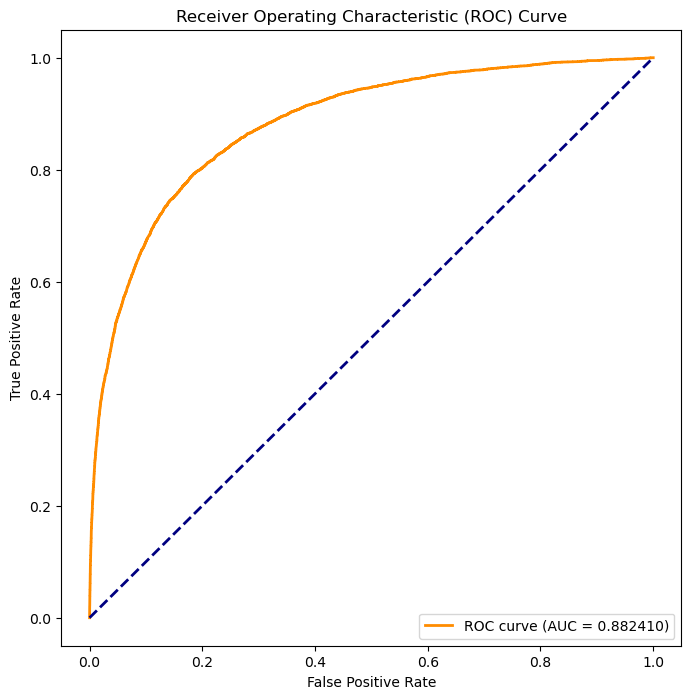

In [24]:
# Predict probabilities on the test set and compute ROC curve and AUC for the Logistic Regression model
y_test_probs = Log.predict_proba(X_test)[:, 1]

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_test_probs)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = {:.6f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [26]:
import warnings
warnings.filterwarnings('ignore')

# Define the parameter grid for GridSearchCV
param_grid = {
    'preprocessor__cat__ohe__min_frequency': [1, 5, 10],
    'classifier__C': [0.1, 1.0, 10.0],
    'classifier__max_iter': [100, 200, 300]
}

# Define the StratifiedKFold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Create the GridSearchCV object
grid_search = GridSearchCV(Log, param_grid, cv=skf, scoring='roc_auc')

# Fit the GridSearchCV on the training data
grid_search.fit(X_train, y_train)

# Print the best parameters and corresponding accuracy
print("Best Parameters: ", grid_search.best_params_)
print("Best Accuracy: ", grid_search.best_score_)

/home/mdsv9/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/mdsv9/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regr

/home/mdsv9/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/mdsv9/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regr

/home/mdsv9/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/mdsv9/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regr

/home/mdsv9/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/mdsv9/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regr

/home/mdsv9/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/mdsv9/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regr

/home/mdsv9/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/mdsv9/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regr

/home/mdsv9/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/mdsv9/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regr

Best Parameters:  {'classifier__C': 0.1, 'classifier__max_iter': 200, 'preprocessor__cat__ohe__min_frequency': 1}
Best Accuracy:  0.8847891463214275


In [27]:
# Create the final Logistic Regression pipeline with the best parameters from GridSearchCV
Log_final = Pipeline(steps = [
    ('preprocessor',preprocessor.set_params(cat__ohe__min_frequency = 1)),
    ('classifier',LogisticRegression(C=0.1,max_iter=200))
])

In [28]:
Log_final.fit(X_train,y_train)

Pipeline(steps=[('preprocessor',
                 FeatureUnion(n_jobs=-1,
                              transformer_list=[('num',
                                                 Pipeline(steps=[('selector',
                                                                  <__main__.FeatureSelector object at 0x7f58923c62c0>),
                                                                 ('std_scaler',
                                                                  StandardScaler())])),
                                                ('cat',
                                                 Pipeline(steps=[('feature_eng',
                                                                  Feature_Creation()),
                                                                 ('selector',
                                                                  <__main__.FeatureSelector object at 0x7f5890a17df0>),
                                                                 ('ohe',
                                                                  OneHotEncoder(handle_unknown='ignore',
                                                                                min_frequency=1))]))])),
                ('classifier', LogisticRegression(C=0.1, max_iter=200))])

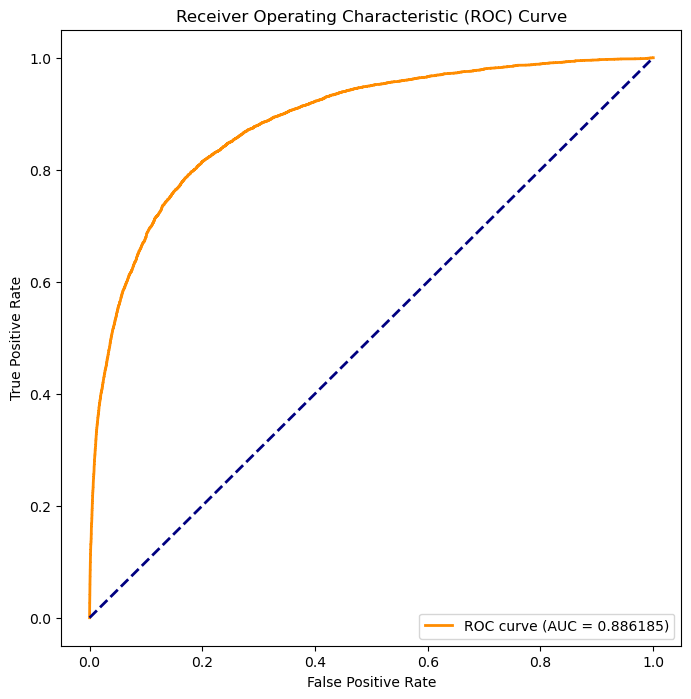

In [29]:
# Predict probabilities on the test set using the final Logistic Regression model
y_test_probs = Log_final.predict_proba(X_test)[:, 1]

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_test_probs)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = {:.6f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

### Advanced Modeling

In [42]:
from sklearn.utils import class_weight

# Calculate class weights using the 'balanced' method
yn = np.unique(y)
class_weight.compute_class_weight('balanced',classes=yn,y=y)

array([0.63419489, 2.36296211])

In [43]:
# Create a pipeline for CatBoostClassifier with feature generation
CBC = Pipeline(steps = [
    ('feature_generator',Feature_Creation()),
    ('classifier',CatBoostClassifier(random_seed=42,
                                     #verbose = 100, 
                                     cat_features=cat_features, 
                                     eval_metric='AUC',
                                     class_weights=[0.63419489, 2.36296211],
                                     verbose=False
                                    ))
])

In [44]:
#Sanity Check
Feature_Creation().fit_transform(X_train).iloc[0]

CustomerId                                    15809838
Surname                                       Genovese
CreditScore                                        726
Geography                                       France
Gender                                          Female
Age                                                350
Tenure                                               1
Balance                                            0.0
NumOfProducts                                        2
HasCrCard                                            1
IsActiveMember                                       1
EstimatedSalary                              1414668.5
IsActive_by_CreditCard                               1
Products_Per_Tenure                                0.5
AllCat                    GenoveseFranceFemale141467.0
Name: 112149, dtype: object

In [45]:
# Define the parameter grid for GridSearchCV for CatBoostClassifier
param_grid = {
    'classifier__one_hot_max_size': [1],
    'classifier__has_time':[False],
    'classifier__learning_rate':[0.001,0.01,0.1],
    'classifier__subsample':[0.05,1],
    'classifier__colsample_bylevel':[0.05,1],
    'classifier__min_data_in_leaf':[10,50,90]
}

# Define the StratifiedKFold
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Create the GridSearchCV object
grid_search = GridSearchCV(CBC, param_grid, cv=skf, scoring='roc_auc')

# Fit the GridSearchCV on the training data
grid_search.fit(X_train, y_train)

# Print the best parameters and corresponding accuracy
print("Best Parameters: ", grid_search.best_params_)
print("Best Accuracy: ", grid_search.best_score_)

Best Parameters:  {'classifier__colsample_bylevel': 1, 'classifier__has_time': False, 'classifier__learning_rate': 0.1, 'classifier__min_data_in_leaf': 10, 'classifier__one_hot_max_size': 1, 'classifier__subsample': 1}
Best Accuracy:  0.8968666064860763


In [47]:
# Create the final CatBoostClassifier pipeline with the best parameters from GridSearchCV
CBC_final = Pipeline(steps=[
    ('preprocess',Feature_Creation()),
    ('classifier',CatBoostClassifier(random_seed=42,
                                     verbose = False,
                                     cat_features=cat_features,
                                     eval_metric='AUC',
                                     colsample_bylevel=1,
                                     has_time=False,
                                     learning_rate=0.1,
                                     min_data_in_leaf=10,
                                     one_hot_max_size=1,
                                     subsample=1
                                    ))
])

In [48]:
CBC_final.fit(X_train,y_train)

Pipeline(steps=[('preprocess', Feature_Creation()),
                ('classifier',
                 <catboost.core.CatBoostClassifier object at 0x7f58829b5e70>)])

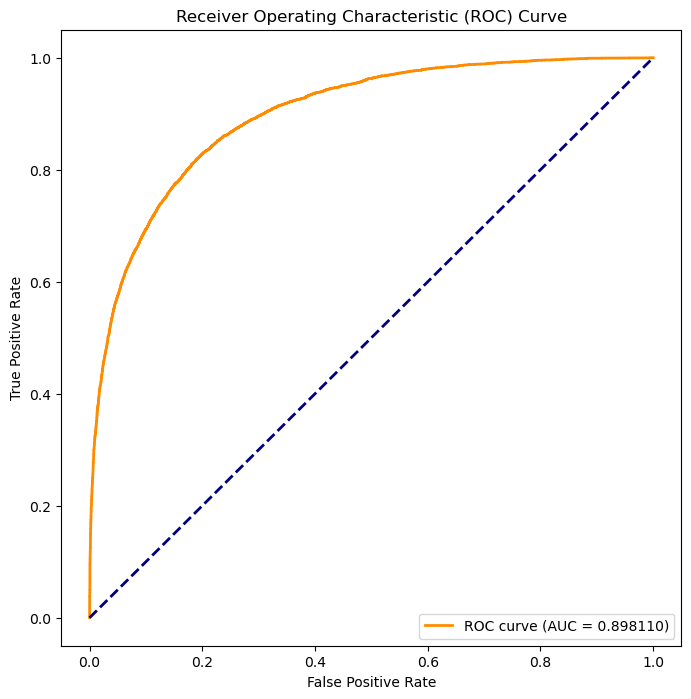

In [49]:
y_test_probs = CBC_final.predict_proba(X_test)[:, 1]

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_test_probs)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = {:.6f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [51]:
print("Final AUC Score:{:.6f} ".format(roc_auc))

Final AUC Score:0.898110 
